# TensorFlow Regression Tutorial 2

### Non-Linear Regression Using Stochastic Gradient Descent (SGD)

It is straight forward to extend the first tutorial in order to perform non-linear regression.  We also revert to using stochastic gradient descent (SGD) instead of full gradient descent, where the former uses mini-batches of the training data as an attempt to approximate the gradient of the loss function.

Once again, we start with creating our non-linear data after importing the necessary modules.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

np.random.seed(1)
%matplotlib inline

In [2]:
# create x and y arrays for then non-linear data
xDat = np.linspace(-1, 1, 300).reshape((-1,1)).astype(np.float32)
noise = np.random.normal(0, 0.05, xDat.shape).astype(np.float32)
yDat = np.exp(xDat) + noise

Let's use the same function defined in the first tutorial in order to add a layer to the network.

In [3]:
def addLayer(inputData, inputSize, outputSize, layerNum, activationFunction = None):
    """
    Adds a new layer to the neural network

    Incoming parameters
    inputData : The tensor that this layer receives from the previous layer (or input layer)
    inputSize : Size (number of neurons) of the input from previous layer.
    outputSize : Size of the output returned by this layer.  Corresponds to the number of neurons
                 in this layer.
    layerNum : Layer number for naming the different layers in tensorboard.
    activationFunction : Type of activation function to use

    Return
    outputs : The output tensor after multiplying the input with the weights and adding the biases.
    """

    # name of this layer
    layerName = "layer_%s"%layerNum

    # define the name scope of this layer
    with tf.name_scope(layerName):

        # initialize weights as a tf variable of size [inputSize, outputSize] 
        # by randomly sampling from a truncated normal distribution
        Weights = tf.Variable(tf.truncated_normal([inputSize, outputSize]), name='Weights')
        tf.summary.histogram("Weights", Weights )

        # initialize the biases to zero as a tf variable of size [1, outputSize]
        biases = tf.Variable(tf.zeros([1, outputSize]), name='biases')
        tf.summary.histogram("biases", biases)

        # perform matrix multiplication of weights and inputs and add biases
        with tf.name_scope("Wx_plus_b"):
            Wx_plus_b = tf.matmul(inputData, Weights) + biases

        # apply the specified activation function if necessary
        if activationFunction is None:
            outputData = Wx_plus_b
        else:
            outputData = activationFunction(Wx_plus_b)

        tf.summary.histogram("outputs", outputData)

        return outputData

A slightly different approach to construct the network is to manually specify a graph using `tf.Graph()`, and then add all the components of the network to that graph.  Since we are doing non-linear regression, we need our network to be more felxible than the one for linear regression.  To do this, we add a hidden layer with 10 neurons, and an output layer with one neuron.  A rectified linear unit is used as activation for the neurons in the hidden layer.

In [4]:
g = tf.Graph()
with g.as_default():
    # define x and y as tf placeholders
    with tf.name_scope("inputs"):
        x = tf.placeholder(np.float32, [None, 1], name='x')
        y = tf.placeholder(np.float32, [None, 1], name='y')

    # add one hidden layer (of 10 neurons) and one output layer (of a single neuron)
    hidden1 = addLayer(x, 1, 10, layerNum=1, activationFunction=tf.nn.relu)
    prediction = addLayer(hidden1, 10, 1, layerNum=2, activationFunction=None)

    # prediction error (loss or cost)
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.square(y-prediction), name='loss')
        tf.summary.scalar("loss", loss)

    # training
    with tf.name_scope("train"):
        train = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

Time to train the model.  In order to perform SGD, we specify a batch size wich will only feed a small chunk of the training data through the network for each training step.  This is achieved by calculating an offset value for indexing the training data.

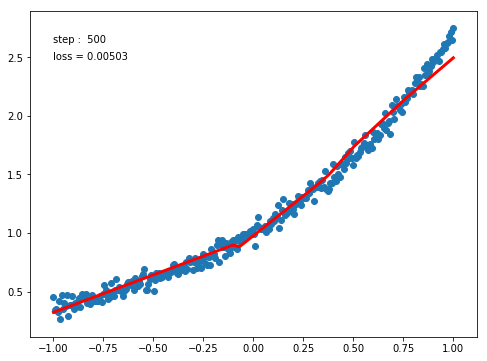

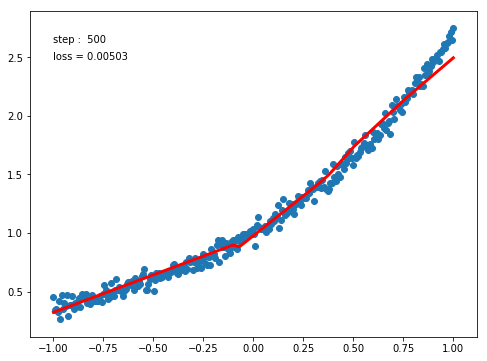

In [5]:
# make a figure and subplot
fig = plt.figure(1, figsize=(8,6))
ax = fig.add_subplot(1,1,1)

# specify the number of training steps
nTrainSteps = 501
batchSize = 30

# start a tf session which will only be active until training ends
with tf.Session(graph=g) as sess:
    # run the variable initializer
    sess.run(tf.global_variables_initializer())
    # define a file writer that will write the logs to a file in a given directory and merge
    writer = tf.summary.FileWriter("logs/", sess.graph)
    merged = tf.summary.merge_all()

    # train the network by running the train step nTrain times
    for i in range(nTrainSteps):
        # calculate an offset at each step (this continually cycles through the dataset)
        offset = (i*batchSize) % (xDat.shape[0] - batchSize)
        # batch arrays for the x-values and y-values of the training data
        xBatch = xDat[offset:offset+batchSize, :]
        yBatch = yDat[offset:offset+batchSize, :]
        sess.run(train, feed_dict={x:xBatch, y:yBatch})
        summaryResult = sess.run(merged, feed_dict={x:xBatch, y:yBatch})
        writer.add_summary(summaryResult, i)

        # plot the current predicted line (with weights and biases) every 5 steps
        if (i%20 == 0):
            # get predicted values
            predictionVals = sess.run(prediction, feed_dict={x:xDat})
            lossVal = sess.run(loss, feed_dict={x:xDat, y:yDat})

            # plot data and predictions
            ax.clear()            
            ax.scatter(xDat, yDat)
            ax.plot(xDat, predictionVals, ls='-', color='r', lw=3)
            plt.text(0.05, 0.9, "step :  {}".format(i), transform=ax.transAxes)
            plt.text(0.05, 0.85, "loss = {0:.{1}}".format(lossVal, 4),transform=ax.transAxes)
            display.clear_output(wait=True)
            plt.pause(0.05)
            display.display(fig)